In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
import os

In [3]:
img_files = os.listdir("pdf2png")

In [4]:
img = cv2.imread("pdf2png/ZUG-GU22_01_IST_20140922-1.png", 0)

In [94]:
img2.shape

(1100, 3109)

In [95]:
img2 = img[600:1700,200:3400]

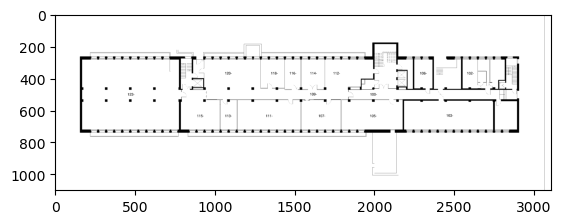

In [96]:
plt.imshow(np.where(img2 > 200, 255, 0), cmap="gray")

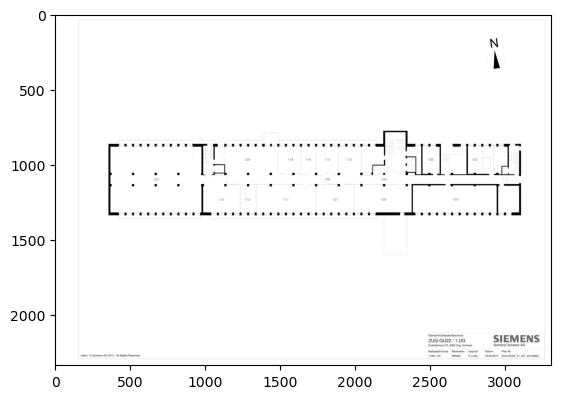

In [97]:
plt.imshow(img, cmap="gray")

In [98]:
img2.shape

(1100, 3109)

In [99]:
img3 = np.where(img2 > 200, 255, 0)

In [100]:
a,b = np.where(img2 <=100)

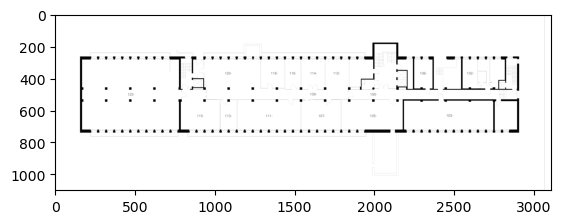

In [101]:
plt.imshow(img2, cmap="gray")

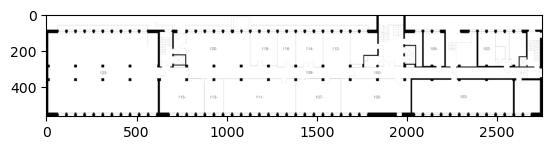

In [102]:
img_cropped = img2[min(a):max(a),min(b):max(b)]
plt.imshow(img_cropped, cmap="gray")

In [103]:
# plt.hist(img2.flatten(), bins=256, range=(0,200))

In [104]:
img_cropped.shape

(562, 2751)

In [38]:
def cornerHarris(img_file,show = True):
    plt.figure(figsize=(50,20))
    img = cv2.imread("pdf2png/" + img_file,0)
    img_gen_crop = img[600:1700,200:3400]
    # whiten the semi-white parts
    img_gen_crop = np.where(img_gen_crop > 200, 255, 0).astype(np.uint8)
    dst = cv2.cornerHarris(img_gen_crop,2,3,0.04)
    dst = cv2.dilate(dst,None)
    # Threshold for an optimal value, it may vary depending on the image.
    img_cropped = np.stack((img_gen_crop,)*3, axis=-1)
    a, b = np.where(dst>0.01*dst.max())
    b_min = min(b)
    a_req_min = np.min(np.where(dst[:,b_min]>0.01*dst[:,b_min].max()))
    b_max = max(b)
    a_req_max = np.max(np.where(dst[:,b_max]>0.01*dst[:,b_max].max()))
    # print(a_min, a_max, b_req_min, b_req_max)
    # img_cropped = np.zeros_like(img_cropped)
    img_cropped[a_req_min, :] = np.array([0,0,255])
    img_cropped[a_req_max, :] = np.array([0,0,255])
    img_cropped[:, b_min] = np.array([0,0,255])
    img_cropped[:, b_max] = np.array([0,0,255])
    if show:
        plt.imshow(img_cropped)
    else:
        plt.imsave("dilated/harris/del_"+img_file,img_cropped,) #cmap=plt.cm.gray)
    

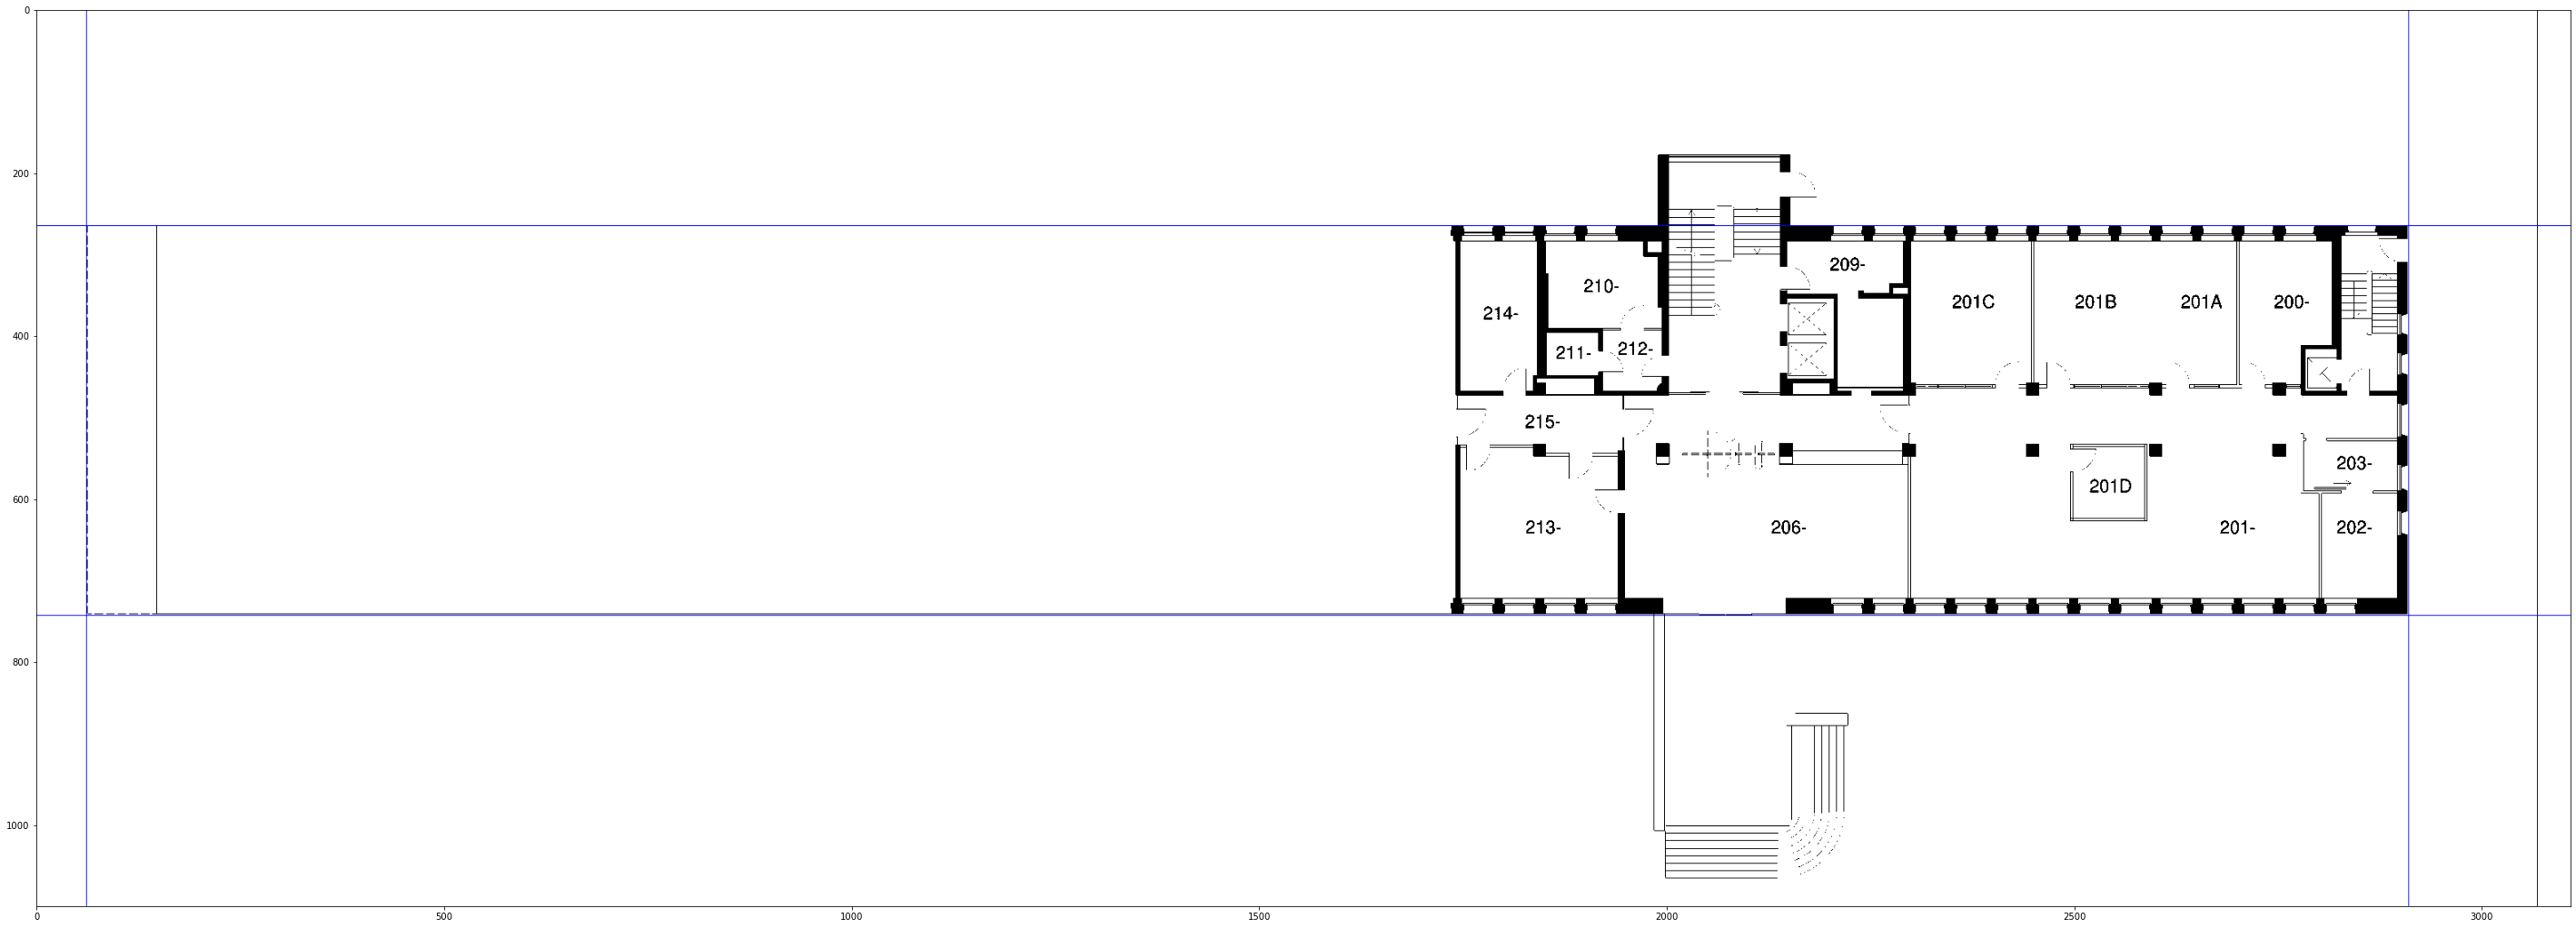

In [39]:
cornerHarris(img_file)

In [18]:
# problem: floor 2 gets cropped out
def hardcode_color(img_file):
    # plt.figure()
    img = cv2.imread("pdf2png/" + img_file,0)
    img_gen_crop = img[600:1700,200:3400]
    # whiten the semi-white parts
    img_cropped = np.where(img_gen_crop > 200, 255, 0).astype(np.uint8)
    a,b = np.where(img_gen_crop <=100)
    # Threshold for an optimal value, it may vary depending on the image.
    img_cropped = img_gen_crop[min(a):max(a),min(b):max(b)]
    plt.imsave("dilated/hardcode/del_"+img_file,img_cropped, cmap=plt.cm.gray)

In [40]:
for img_file in img_files:
    cornerHarris(img_file,show=False)

<Figure size 3600x1440 with 0 Axes>

<Figure size 3600x1440 with 0 Axes>

<Figure size 3600x1440 with 0 Axes>

<Figure size 3600x1440 with 0 Axes>

<Figure size 3600x1440 with 0 Axes>

<Figure size 3600x1440 with 0 Axes>

<Figure size 3600x1440 with 0 Axes>

<Figure size 3600x1440 with 0 Axes>

In [116]:
cornerHarris(img_file)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


<Figure size 640x480 with 0 Axes>